In [1]:
import os
import time
import datetime

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from tqdm import tqdm

from utils.OpticalFlowUtils import FlowReader
from utils.OpticalFlowUtils import FlowVisualiser

from utils.MPISintelUtils import MPISintelHandler

from assets.ml.src.FlowConv import FlowConvNet
from assets.ml.src.CustomLosses import AE_Loss
from assets.ml.src.CustomLosses import EPE_Loss
from assets.ml.src.CustomCallbacks import PredictOnEpochEndCallback
from assets.ml.src.ConvolutionalFlowRefiner import FlowRefinerConvNet

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 8.1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8.1)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(f"Runtime Error: {e}")

1 Physical GPUs, 1 Logical GPUs


In [3]:
reader = FlowReader()
visualiser = FlowVisualiser()
dataHandler = MPISintelHandler()

In [4]:
SINTEL_PATH = os.path.join("..", "Data", "MPI-Sintel")
SINTEL_TRAINING_PATH = os.path.join(SINTEL_PATH, "training")
SINTEL_TRAINING_FLOW_PATH = os.path.join(SINTEL_TRAINING_PATH, "flow")
SINTEL_TRAINING_IMG_PATH = os.path.join(SINTEL_TRAINING_PATH, "clean")

In [5]:
print(f"SINTEL PATH: {SINTEL_PATH}")
print(f"SINTEL TRAINING PATH: {SINTEL_TRAINING_PATH}")
print(f"SINTEL TRAINING FLOW PATH: {SINTEL_TRAINING_FLOW_PATH}")
print(f"SINTEL TRAINING IMG PATH: {SINTEL_TRAINING_IMG_PATH}")

SINTEL PATH: ..\Data\MPI-Sintel
SINTEL TRAINING PATH: ..\Data\MPI-Sintel\training
SINTEL TRAINING FLOW PATH: ..\Data\MPI-Sintel\training\flow
SINTEL TRAINING IMG PATH: ..\Data\MPI-Sintel\training\clean


In [6]:
# load the data from the file after the file has been organised
dataFilepath = os.path.join(".", "assets", "data", "trainImages.data")
trainImgsArray = dataHandler.loadData(dataFilepath)

dataFilepath = os.path.join(".", "assets", "data", "trainFlows.data")
trainFlowsArray = dataHandler.loadData(dataFilepath)

trainImgsArray = trainImgsArray.astype('float32') / 255.0
trainFlowsArray = trainFlowsArray.astype('float32')
trainImgsArray = tf.reshape(trainImgsArray, shape=(-1, 2, 436, 1024, 1))

In [7]:
# Ensure the data has the same shape
print(f"Train images shape: {trainImgsArray.shape}")
print(f"Train flows shape: {trainFlowsArray.shape}")

Train images shape: (1041, 2, 436, 1024, 1)
Train flows shape: (1041, 436, 1024, 2)


In [6]:
# Load the split data 
dataFilepath = os.path.join(".", "assets", "data", "trainX.data")
train_X = dataHandler.loadData(dataFilepath)
train_X = train_X.astype('float32') / 255.0
train_X = tf.reshape(train_X, shape=(-1, 2, 436, 1024, 1))

dataFilepath = os.path.join(".", "assets", "data", "testX.data")
test_X = dataHandler.loadData(dataFilepath)
test_X = test_X.astype('float32') / 255.0
test_X = tf.reshape(test_X, shape=(-1, 2, 436, 1024, 1))

dataFilepath = os.path.join(".", "assets", "data", "valX.data")
val_X = dataHandler.loadData(dataFilepath)
val_X = val_X.astype('float32') / 255.0
val_X = tf.reshape(val_X, shape=(-1, 2, 436, 1024, 1))

dataFilepath = os.path.join(".", "assets", "data", "trainy.data")
train_y = dataHandler.loadData(dataFilepath)
train_y = train_y.astype('float32')

dataFilepath = os.path.join(".", "assets", "data", "testy.data")
test_y = dataHandler.loadData(dataFilepath)
test_y = test_y.astype('float32')

dataFilepath = os.path.join(".", "assets", "data", "valy.data")
val_y = dataHandler.loadData(dataFilepath)
val_y = val_y.astype('float32')

In [7]:
print(f"train_X: {train_X.shape} test_X: {test_X.shape} val_X: {val_X.shape} -> Total Samples: {train_X.shape[0] + test_X.shape[0] + val_X.shape[0]}")
print(f"train_y: {train_y.shape} test_y: {test_y.shape} val_y: {val_y.shape} -> Total Samples: {train_y.shape[0] + test_y.shape[0] + val_y.shape[0]}")

train_X: (510, 2, 436, 1024, 1) test_X: (297, 2, 436, 1024, 1) val_X: (234, 2, 436, 1024, 1) -> Total Samples: 1041
train_y: (510, 436, 1024, 2) test_y: (297, 436, 1024, 2) val_y: (234, 436, 1024, 2) -> Total Samples: 1041


In [8]:
# Use tensorboard to visualise training progress and all the fun things
%load_ext tensorboard

In [9]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"FlowConvNET_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch= '10, 110')

modelDir = os.path.join(".", "assets", "ml", "models", "FlowConvNet")
if not os.path.exists(modelDir):
    os.makedirs(modelDir)

modelPath = os.path.join(modelDir, "FlowConvNET.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.85, patience=50, min_lr=1e-6)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]

callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

In [9]:
%tensorboard --logdir ./assets/logs --port=8077

In [11]:
flowConvNet = FlowConvNet()
angularError = AE_Loss()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
flowConvNet.compile(optimizer=optimizer, loss=EPE_Loss(), metrics = ['mse'])
flowConvNet.build(input_shape=(None, 2, 436, 1024, 1))
flowConvNet.summary()

Model: "flow_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  608       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  73792     
                                                                 
 up_sampling2d (UpSampling2D  multiple                 0         
 )                                                   

In [12]:
hist = flowConvNet.fit(x=train_X, y=train_y, epochs = 2500, verbose = True, batch_size=1, validation_data=(test_X, test_y), callbacks=_callbacks)

Epoch 1/2500
510/510 [==============================] - 40s 72ms/step - loss: 12.5186 - mse: 363.8771 - val_loss: 13.9716 - val_mse: 411.8213 - lr: 0.0010
Epoch 2/2500
510/510 [==============================] - 33s 65ms/step - loss: 12.5162 - mse: 364.0710 - val_loss: 13.9735 - val_mse: 411.8471 - lr: 0.0010
Epoch 3/2500
510/510 [==============================] - 33s 64ms/step - loss: 12.5043 - mse: 363.4775 - val_loss: 13.9311 - val_mse: 410.4369 - lr: 0.0010
Epoch 4/2500
510/510 [==============================] - 39s 76ms/step - loss: 12.4894 - mse: 363.8675 - val_loss: 13.9230 - val_mse: 410.3984 - lr: 0.0010
Epoch 5/2500
510/510 [==============================] - 36s 71ms/step - loss: 12.4999 - mse: 363.9308 - val_loss: 13.9704 - val_mse: 411.7862 - lr: 0.0010
Epoch 6/2500
510/510 [==============================] - 35s 69ms/step - loss: 12.4919 - mse: 363.8347 - val_loss: 13.9716 - val_mse: 411.7610 - lr: 0.0010
Epoch 7/2500
510/510 [==============================] - 32s 62ms/step 

In [13]:
def visualiseFits(fits, validationData = True):
    fig, axs = plt.subplots(2, 2, figsize = (40, 20))

    axs[0][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[0][0].legend()
    axs[0][0].set_xlabel("Epochs")
    axs[0][0].set_ylabel("EPE (log Scaled)")
    axs[0][0].set_yscale('log')
    axs[0][0].grid(True)

    axs[1][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[1][0].legend()
    axs[1][0].set_xlabel("Epochs")
    axs[1][0].set_ylabel("EPE")
    axs[1][0].grid(True)

    axs[0][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[0][1].legend()
    axs[0][1].set_xlabel("Epochs")
    axs[0][1].set_ylabel("MSE")
    axs[0][1].grid(True)

    axs[1][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[1][1].legend()
    axs[1][1].set_xlabel("Epochs")
    axs[1][1].set_ylabel("MSE (log scaled)")
    axs[1][1].set_yscale('log')
    axs[1][1].grid(True)
    
    if validationData:
        axs[0][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[1][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[0][1].plot(fits.history['val_mse'], label = "Conventional NN Train MSE validation")
        axs[1][1].plot(fits.history['val_mse'], label = "Conventional NN Train MAE validation")

    plt.show()

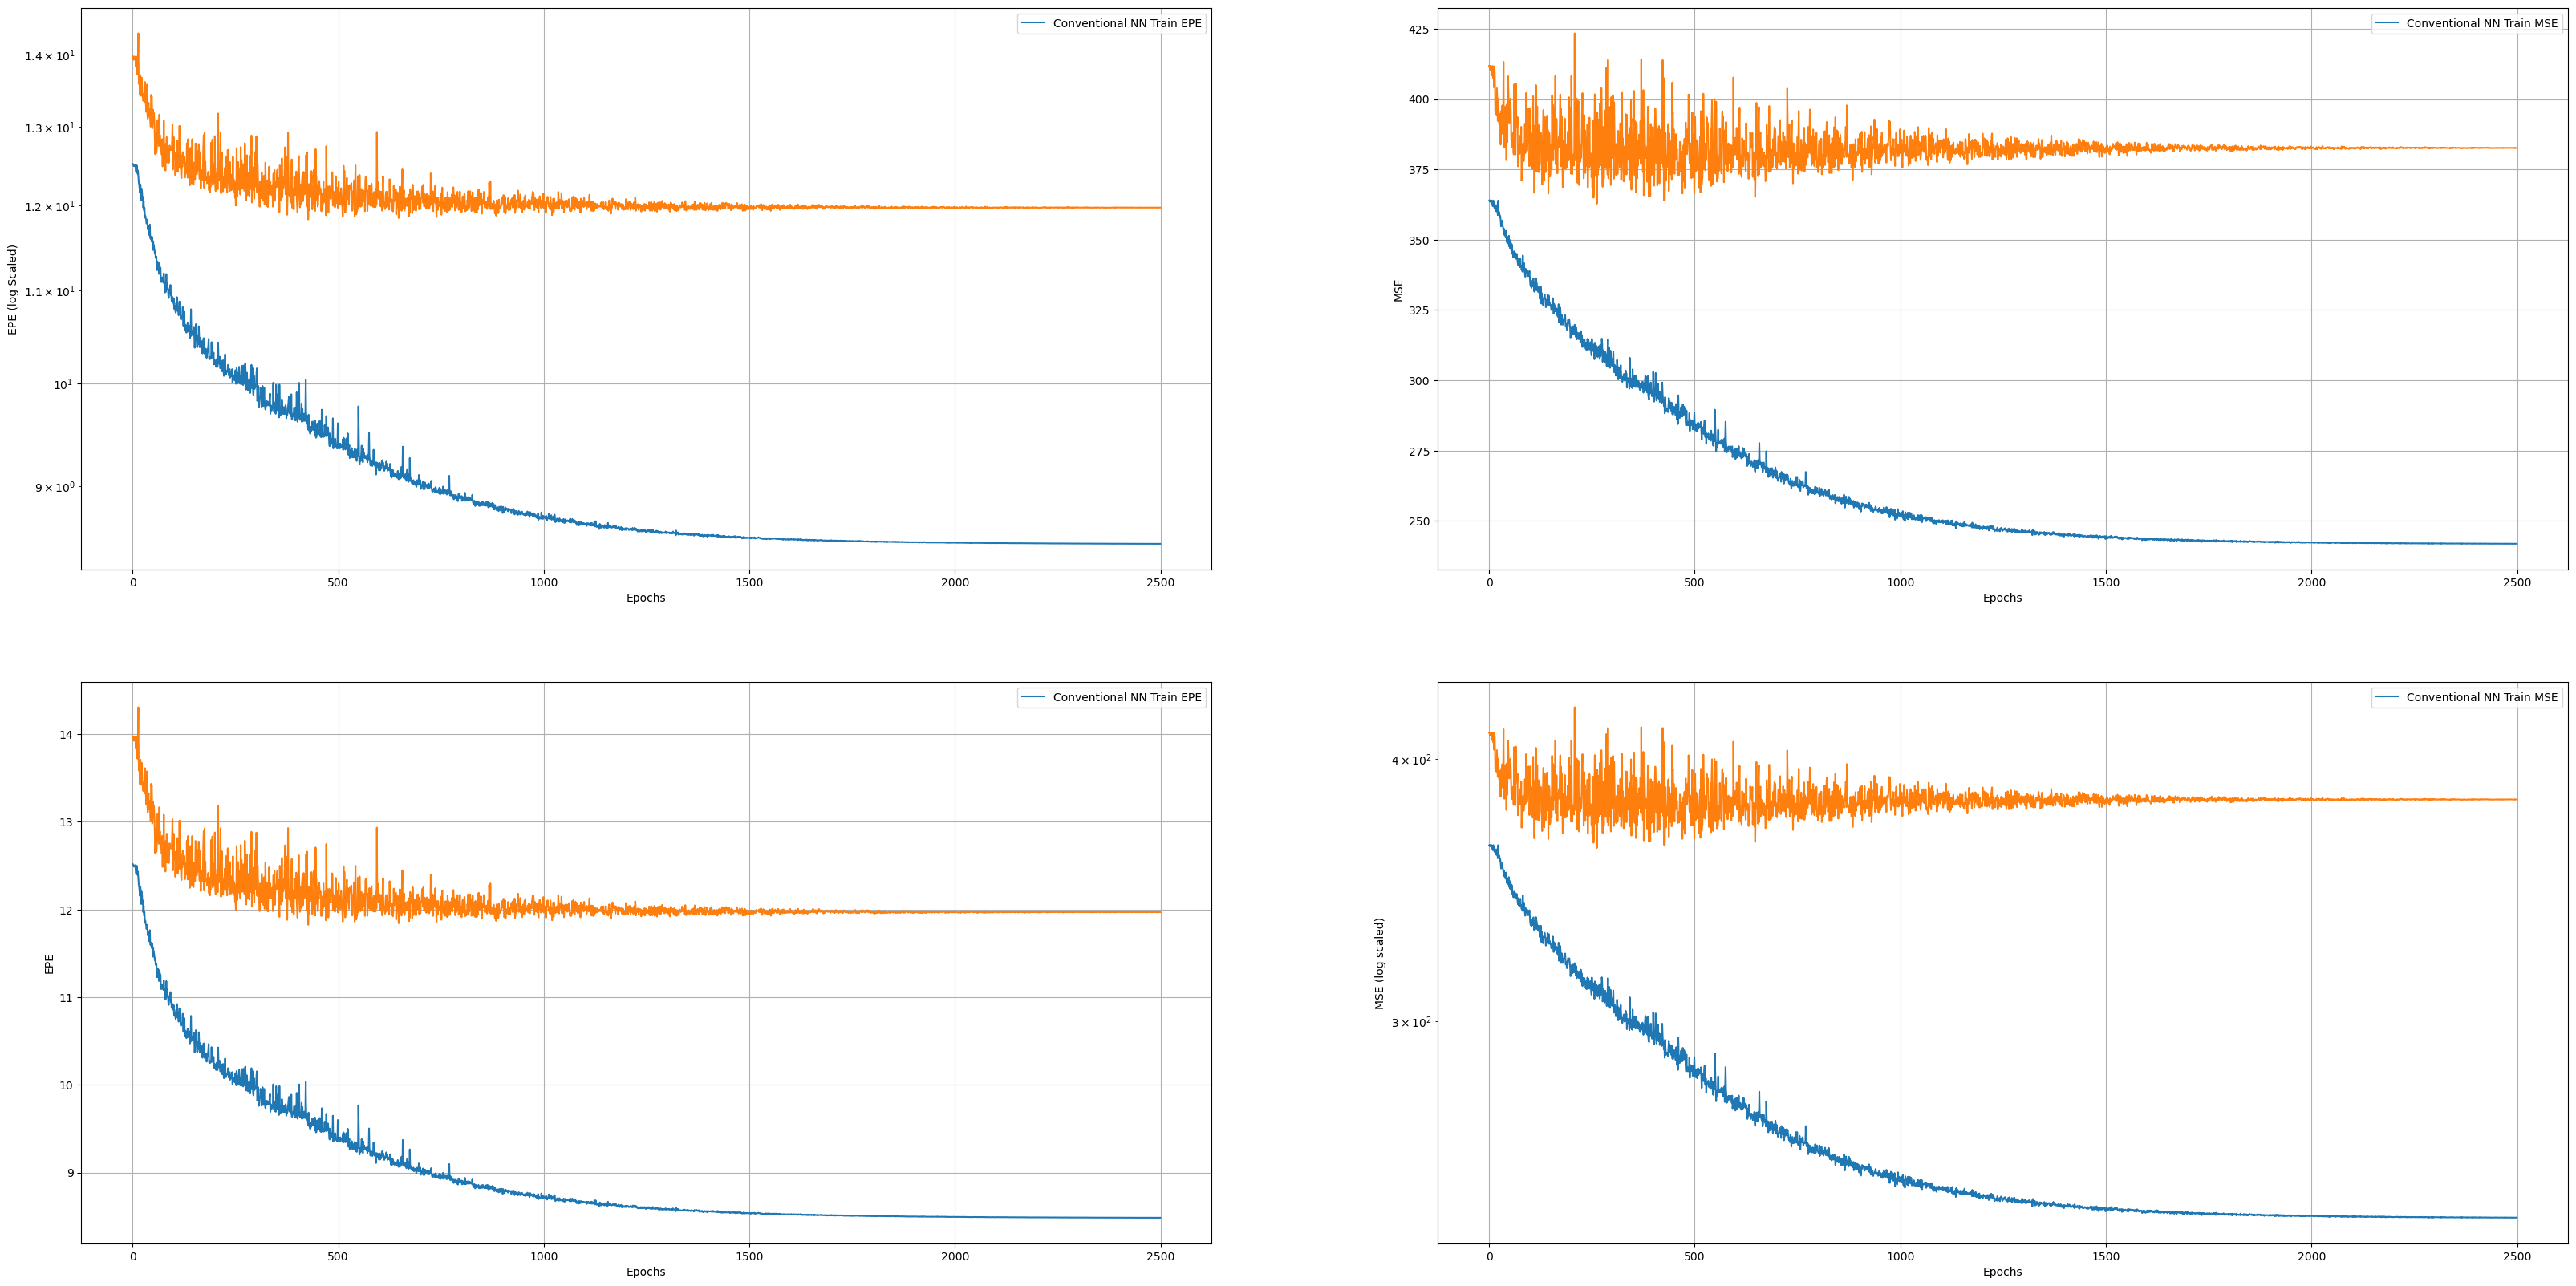

In [14]:
visualiseFits(hist)

In [10]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"FlowRefinerNET_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch= '10, 110')

modelDir = os.path.join(".", "assets", "ml", "models", "FlowRefinerNet")
if not os.path.exists(modelDir):
    os.makedirs(modelDir)

modelPath = os.path.join(modelDir, "FlowRefinerNET.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.85, patience=50, min_lr=1e-6)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]

callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

In [11]:
flowRefinerNET = FlowRefinerConvNet()
angularError = AE_Loss()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
flowRefinerNET.compile(optimizer=optimizer, loss=EPE_Loss(), metrics = ['mse'])
flowRefinerNET.build(input_shape=(None, 2, 436, 1024, 1))
flowRefinerNET.summary()

Model: "flow_refiner_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flow_conv_net (FlowConvNet)  multiple                 185794    
                                                                 
 conv2d_6 (Conv2D)           multiple                  592       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           multiple                  4640      
                                                                 
 conv2d_8 (Conv2D)           multiple                  9248      
                                                                 
 conv2d_9 (Conv2D)           multiple                  9248      
                                             

In [12]:
hist = flowRefinerNET.fit(x=train_X, y=train_y, epochs = 2500, verbose = True, batch_size=1, validation_data=(test_X, test_y), callbacks=_callbacks)

Epoch 1/2500
510/510 [==============================] - 60s 105ms/step - loss: 12.5144 - mse: 363.9660 - val_loss: 13.9362 - val_mse: 410.7587 - lr: 0.0010
Epoch 2/2500
510/510 [==============================] - 46s 89ms/step - loss: 12.5025 - mse: 363.6111 - val_loss: 13.9690 - val_mse: 411.6136 - lr: 0.0010
Epoch 3/2500
510/510 [==============================] - 41s 80ms/step - loss: 12.4982 - mse: 363.7169 - val_loss: 13.9339 - val_mse: 410.2228 - lr: 0.0010
Epoch 4/2500
510/510 [==============================] - 35s 69ms/step - loss: 12.4836 - mse: 363.4577 - val_loss: 13.8884 - val_mse: 408.7058 - lr: 0.0010
Epoch 5/2500
510/510 [==============================] - 35s 69ms/step - loss: 12.5003 - mse: 363.6901 - val_loss: 13.9458 - val_mse: 410.3988 - lr: 0.0010
Epoch 6/2500
510/510 [==============================] - 36s 70ms/step - loss: 12.4713 - mse: 363.7164 - val_loss: 13.7907 - val_mse: 405.6516 - lr: 0.0010
Epoch 7/2500
510/510 [==============================] - 35s 69ms/step

In [13]:
def visualiseFits(fits, validationData = True):
    fig, axs = plt.subplots(2, 2, figsize = (40, 20))

    axs[0][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[0][0].legend()
    axs[0][0].set_xlabel("Epochs")
    axs[0][0].set_ylabel("EPE (log Scaled)")
    axs[0][0].set_yscale('log')
    axs[0][0].grid(True)

    axs[1][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[1][0].legend()
    axs[1][0].set_xlabel("Epochs")
    axs[1][0].set_ylabel("EPE")
    axs[1][0].grid(True)

    axs[0][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[0][1].legend()
    axs[0][1].set_xlabel("Epochs")
    axs[0][1].set_ylabel("MSE")
    axs[0][1].grid(True)

    axs[1][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[1][1].legend()
    axs[1][1].set_xlabel("Epochs")
    axs[1][1].set_ylabel("MSE (log scaled)")
    axs[1][1].set_yscale('log')
    axs[1][1].grid(True)
    
    if validationData:
        axs[0][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[1][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[0][1].plot(fits.history['val_mse'], label = "Conventional NN Train MSE validation")
        axs[1][1].plot(fits.history['val_mse'], label = "Conventional NN Train MAE validation")

    plt.show()

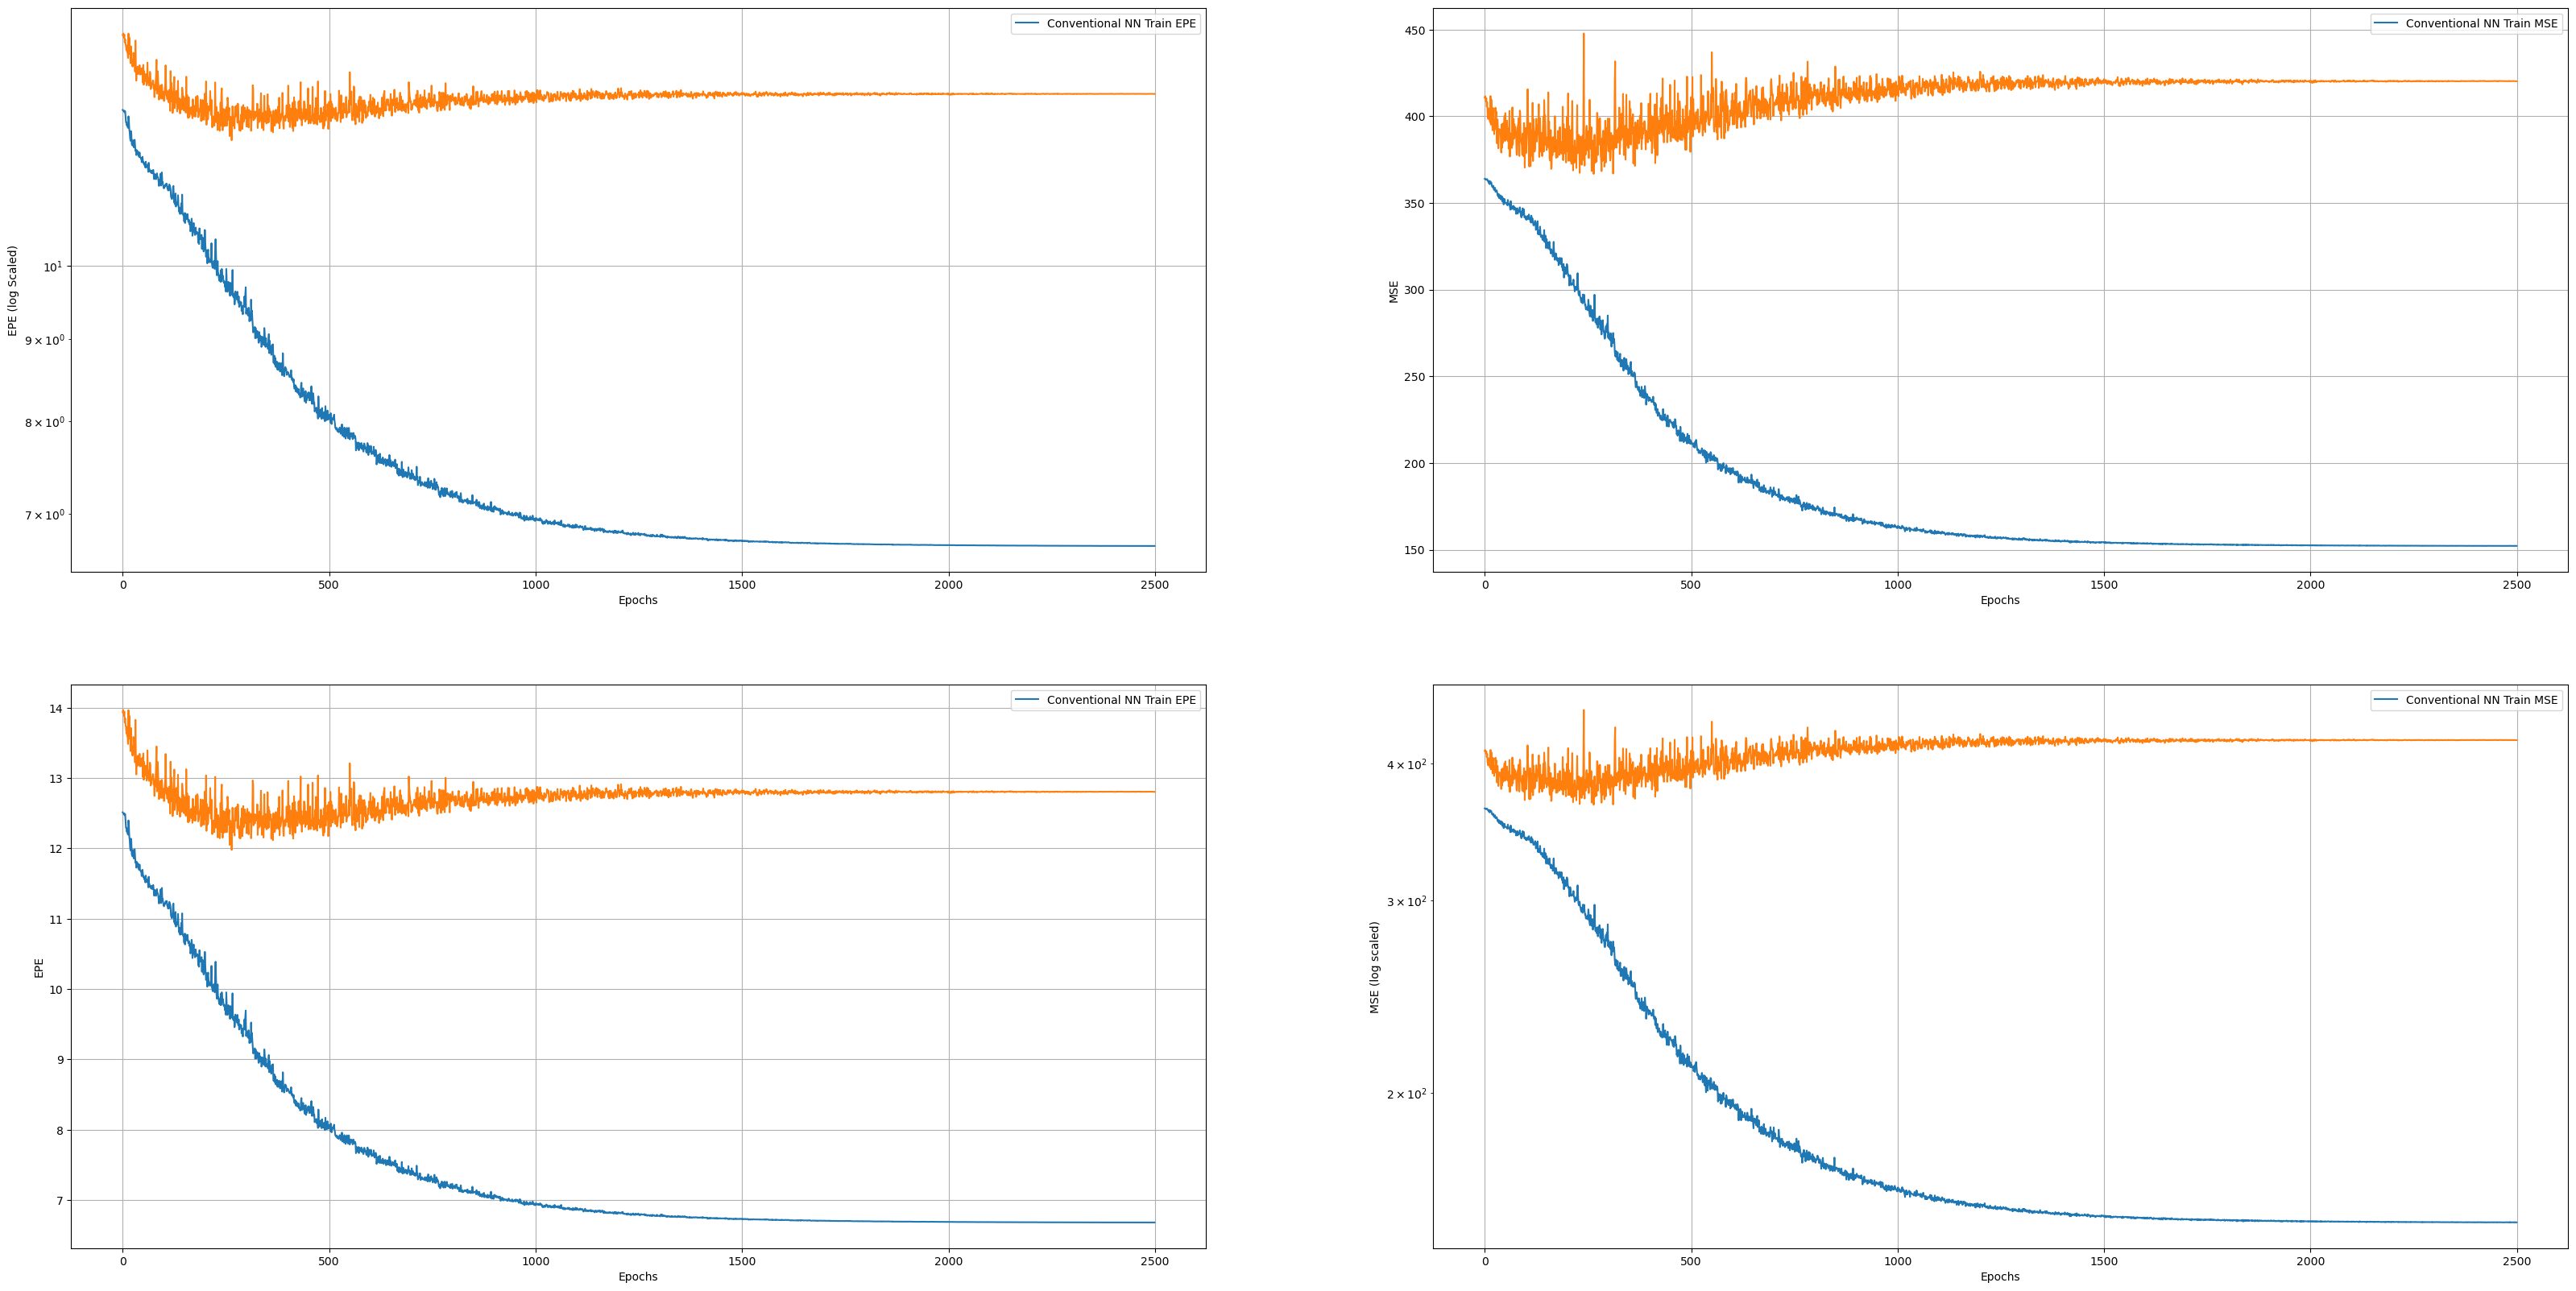

In [14]:
visualiseFits(hist)